In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow.keras import layers
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
import imageio
import moviepy.editor as mpy

import re
from IPython import display

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2022-01-09 15:16:00.650519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 15:16:00.655674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 15:16:00.656021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 15:16:00.656889: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Hyperparameter setting
* In this part, we used the setting in lab and competetion template

In [ ]:
IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

dataset_size = 7370

Z_DIM = 128
text_dim = 128
BATCH_SIZE = 64
BZ = (BATCH_SIZE, 1, 1, 50)

W_LR = 2.0e-04
W_beta1 = 0.5
W_beta2 = 0.99
W_EPOCH = 1500

data_path = './dataset'
image_dir = ''

hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 50,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 600,
    'CHECKPOINTS_DIR': './checkpoints/final',  
    'PRINT_FREQ': 1                           
}

# Image preprocess
* We preprocessed the data by resizeing, cropping, padding, and random flip left and right.
* We generated the dataset which description didn't match it's image for the loss in conditional-GAN

In [ ]:
def image_preprocess(img):
    img = tf.image.decode_jpeg(img, channels=3)
    short_side = tf.minimum(tf.shape(img)[0], tf.shape(img)[1])
    img = tf.image.resize_with_crop_or_pad(img, short_side, short_side)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32)
    img = tf.clip_by_value(img, 0, 255)
    img = img/127.5 - 1.0
    return img

def training_data_generator(captions, image_path, wrong_image_path):
    img = tf.io.read_file(image_dir+image_path)
    img = image_preprocess(img)
    wrong_img = tf.io.read_file(image_dir+wrong_image_path)
    wrong_img = image_preprocess(wrong_img)  
    caption = random.choice(captions)[:2400]
    return img, wrong_img, caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    real_image_path = df['ImagePath'].values
    wrong_image_path = tf.random.shuffle(real_image_path)
    
    dataset = tf.data.Dataset.from_tensor_slices((st, real_image_path, wrong_image_path))
    dataset = dataset.repeat(5)
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(5000).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
class EmbeddingCompressor(tf.keras.Model):
    def __init__(self):
        super(EmbeddingCompressor, self).__init__()
        self.dense = tf.keras.layers.Dense(units = 128) # 128

    def call(self, E):
        X = self.dense(E)
        return tf.nn.leaky_relu(X)

# Model Architecture
* We reference some papers or github pages for building our model.  

In [ ]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = EmbeddingCompressor() # DENSE_DIM = 128
        self.d2 = tf.keras.layers.Dense(units = 128*4*4*4, kernel_initializer = tf.random_normal_initializer(stddev = 0.02))
        self.reshape = tf.keras.layers.Reshape(target_shape = (4, 4, 128*4), input_shape = (128*4*4*4, ))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.batchnorm0 = tf.keras.layers.BatchNormalization()
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        self.batchnorm5 = tf.keras.layers.BatchNormalization()
        self.batchnorm7 = tf.keras.layers.BatchNormalization()
        self.batchnorm8 = tf.keras.layers.BatchNormalization()
        self.batchnorm6 = tf.keras.layers.BatchNormalization()
        self.conv_same1 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 4, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv_same2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 4, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv_same3 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 4, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv_same4 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 4, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv_same5 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 4, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv_same6 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 4, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv_same7 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 4, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv_same8 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 4, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.reshape = tf.keras.layers.Reshape(target_shape = (4, 4, 128*4), input_shape = (128*4*4*4, ))
        self.deconv = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = 4, strides = (2, 2), padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.deconv0 = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = 4, strides = (2, 2), padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.deconv1 = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = 4, strides = (2, 2), padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.deconv2 = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = 4, strides = (2, 2), padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.deconv3 = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = 4, strides = (2, 2), padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.deconv4 = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = 4, strides = (2, 2), padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv1 = tf.keras.layers.Conv2D(filters = 256, kernel_size =1 , strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 1, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv3 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 1, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
        self.conv4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 1, strides = 1, padding = "same", kernel_initializer = tf.keras.initializers.TruncatedNormal())
    def call(self, text, noise_z):
        text = self.d1(text)
        
        text = tf.expand_dims(text, axis=1)
        text = tf.expand_dims(text, axis=1)
        
        noise_z = tf.expand_dims(noise_z, axis=1)
        noise_z = tf.expand_dims(noise_z, axis=1)
        
        img = tf.concat([text, noise_z], axis=3)
        X = self.deconv(img)
        X = self.batchnorm(X)
        X = tf.nn.leaky_relu(X)
        X = self.deconv0(X)
        X = self.batchnorm0(X)
        X = tf.nn.leaky_relu(X)
        

        # ResBlock
        X = self.conv_same1(X)
        X = self.batchnorm1(X)
        img = self.conv1(img)
        X = tf.nn.leaky_relu(X)
        X = self.conv_same2(X)
        X = self.batchnorm2(X) + img
        X = tf.nn.leaky_relu(X)

        # Up-sampling
        Res_X = self.deconv1(X)
        
        
        # ResBlock
        X = self.conv_same3(Res_X)
        X = self.batchnorm3(X)
        Res_X = self.conv2(Res_X)
        X = tf.nn.leaky_relu(X)
        X = self.conv_same4(X)
        X = self.batchnorm4(X) + Res_X
        X = tf.nn.leaky_relu(X)

        # Up-sampling
        Res_X = self.deconv2(X)
        
        
        # ResBlock
        X = self.conv_same5(Res_X)
        X = self.batchnorm5(X)
        Res_X = self.conv3(Res_X)
        X = tf.nn.leaky_relu(X)
        X = self.conv_same6(X)
        X = self.batchnorm6(X) + Res_X
        X = tf.nn.leaky_relu(X)

        # Up-sampling
        Res_X = self.deconv3(X)
        
        
        # ResBlock
        X = self.conv_same7(Res_X)
        X = self.batchnorm7(X)
        Res_X = self.conv4(Res_X)
        X = tf.nn.leaky_relu(X)
        X = self.conv_same8(X)
        X = self.batchnorm8(X) + Res_X
        X = tf.nn.leaky_relu(X)

        # Up-sampling
        logits = self.deconv4(X)
        output = tf.nn.tanh(logits)
        
        return output

In [ ]:
generator = Generator(hparas)

In [ ]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [ ]:
def sample_generator(captions_test):
    captions_test = np.asarray(captions_test)
    dataset = tf.data.Dataset.from_tensor_slices(captions_test)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
st_check = np.load('./dataset/sample_captions.npy')

In [ ]:
ni = int(np.ceil(np.sqrt(BATCH_SIZE)))
sample_size = BATCH_SIZE
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, 1, 1, Z_DIM)).astype(np.float32)
sample_sentence = [st_check[1][0][:2400]] * int(sample_size/ni) + \
                  [st_check[2][0][:2400]] * int(sample_size/ni) + \
                  [st_check[3][0][:2400]] * int(sample_size/ni) + \
                  [st_check[4][0][:2400]] * int(sample_size/ni) + \
                  [st_check[5][0][:2400]] * int(sample_size/ni) + \
                  [st_check[6][0][:2400]] * int(sample_size/ni) + \
                  [st_check[7][0][:2400]] * int(sample_size/ni) +\
                  [st_check[7][0][:2400]] * int(sample_size/ni)

sample_sentence = sample_generator(sample_sentence)

In [ ]:
ckpt = tf.train.Checkpoint(generator=generator)

# manager = tf.train.CheckpointManager(ckpt, '/home/haowei/CS565600_Deep_Learning/DL_comp3/checkpoints/chiu_80_ver6mergeOu_checker_new_propotion', max_to_keep=1500)

In [ ]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [ ]:
ckpt.restore('./checkpoints/final' + '/ckpt-750')

In [ ]:
def testing_data_generator(captions, index):
    caption = captions[0][:2400]
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData.pkl')
    st = np.load('./dataset/test_captions.npy')
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((st, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

testing_dataset = testing_dataset_generator(BATCH_SIZE, testing_data_generator)

In [ ]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

In [ ]:
@tf.function
def test_step(caption, noise):
    text_embed = caption
    fake_image = generator(text_embed, noise)
    return fake_image

In [ ]:
def inference(dataset):
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [ ]:
inference(testing_dataset)

Time for inference is 0.6894 sec


In [ ]:
def visualize(idx):
    fig = plt.figure(figsize=(14, 14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        
        path = './inference/inference_{:04d}.jpg'.format(i)
        fake_iamge = plt.imread(path)
        
        plt.subplot(7, 7, count+1)
        plt.imshow(fake_iamge)
        plt.axis('off')

In [ ]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


# Inference the result

42
flower with white long white petals and very long purple stamen 
this medium white flower has rows of thin blue petals and thick stamen 
this flower is white and purple in color with petals that are oval shaped 
this flower is pink and yellow in color with petals that are oval shaped 
the flower has a large bright orange petal with pink anther 
the flower shown has a smooth white petal with patches of yellow as well 
white petals that become yellow as they go to the center where there is an orange stamen 
this flower has bright red petals with green pedicel as its main features 
this flower has the overlapping yellow petals arranged closely toward the center 
this flower has green sepals surrounding several layers of slightly ruffled pink petals 
the pedicel on this flower is purple with a green sepal and rose colored petals 
this white flower has connected circular petals with yellow stamen 
the flower has yellow petals overlapping each other and are yellow in color 
this flower ha

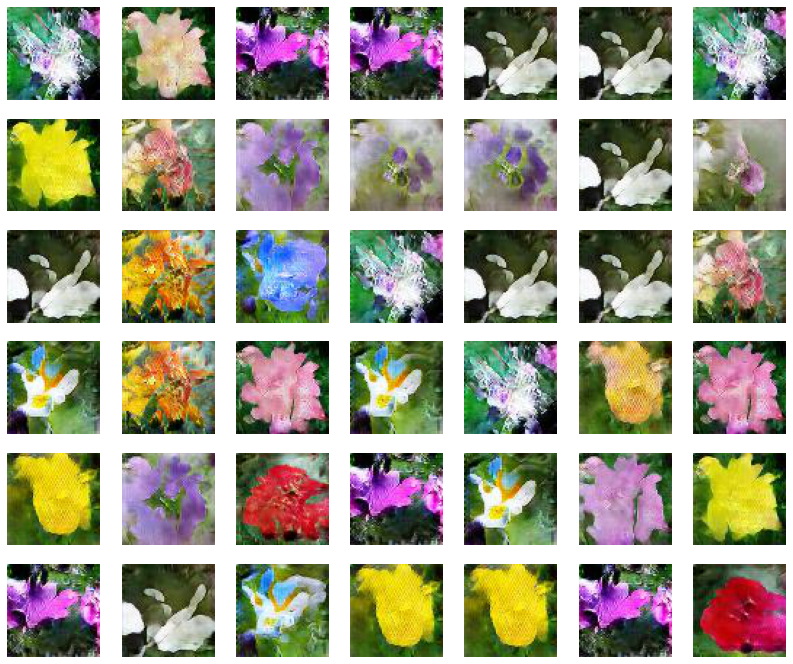

In [ ]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
random_idx = [23, 216, 224, 413, 713, 859, 876, 974, 1177, 1179, 1241, 2169, 2196, 2237, 
              2356, 2611, 2621, 2786, 2951, 2962, 3145, 3255, 3327, 3639, 3654, 3927, 4262, 
              4321, 4517, 5067, 5147, 5955, 6167, 6216, 6410, 6413, 6579, 6584, 6804, 6988, 
              7049, 7160]

print(len(random_idx))
visualize(random_idx)

# Report

## Models you tried during competition

### Text encoder:
We tried three kinds of model for text encoding, GRU, Bert, and Skip-thoughts. And we got 0.64, 0.63, 0.61 on public score respectively.
Finally, we chose Skip-thoughts as our text encoder. It needed to download the pretrian model and weight from github(https://github.com/ryankiros/skip-thoughts), and fed the condition sentence sentences to get the embedding and transformed the result to .npy file. 

### GAN:
We used the original conditional GAN as our baseline, we follow the paper to bulid our model. But we noticed the "Condition Augmentation" which can add some noise to the given embedding will fool the generator to generate the image mismatch to the sentence, so we remove it, we guessed it was due to our small dataset. After we passed the baseline60, we want to try StackGAN, but we noticed that it would take many time when training stage2, so we gave up. Maybe next time we should start our project as soon as possible. :-(



## List the experiment you did

### Data augmentation
We use resize_with_crop_or_pad and random_flip_left_right to augment the original image first, after that we size it to 64*64.

### Hyper-parameters tuning
For the hyper parameter tuning, we just used the origin setting in the lab and task.

### Architecture tuning
For the "Generator", we tried original conditional GAN as our baseline, we follow the paper to bulid our model. But we noticed the "Condition Augmentation" which can add some noise to the given embedding will fool the generator to generate the image mismatch to the sentence, so we remove it. After that, we find some paper used residual block to help training, so we add it to our model. As for the "Discriminator", we also added more layers when the generated image mismatch to the sentence because we thought this circumstance in result from the poor discriminator.

### Optimizer tuning
For the training optimizer, we only used Adam as our optimizer because most of the paper used this way. And for each training step, we trained the discriminator for three times and generator for one time.

# Anything worth mentioning

# Anything worth mentioning

### Skip-thoughts V.S. Bert
We find some difference between these two encoders when we applied them to our task. For Bert pretrain on Imagenet, because it had learned too many words before, it may embedded our sentence in similar sequence. This result would make our sentence mismatch to the image because the generator couldn't recognize the little difference between them. As for Skip-thoughts, it can encode the whole sentence instead of a word, and it can predict next sentence and previous sentence. It can make the generated image more match to the given sentence. However, the image generated by the embedded from Bert was more like real flowers. So for the competition, we used one result from Bert but we train the discriminator more times and add more layers to it. And the others versions we used the skip-thoughts as text-encoder.

###  Training step and loss
We used the training step in the template fist, however, we notice that it is unreasonable because it update the generator and discriminator's optimizer in the same time, so we modified the training step similar to lab sample, we train and update the discriminator for 3 times and the generator for 1 times respectively. We also used the wgan loss to train it and got better result on public score. For the loss, beside (real image, caption), (fake image, caption), we follow the paper and add a new loss pair (real image, mismatch caption) when counting generator loss.